## Importing libraries

In [1]:
 # Operations
import pandas as pd, numpy as np, plotly.express as px

# Visualization
from plotly.subplots import make_subplots 
import matplotlib.pyplot as plt 
import seaborn as sns 

# Preprocessing & Evaluation Metrics
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, recall_score 
from sklearn.preprocessing import FunctionTransformer
from imblearn.over_sampling import RandomOverSampler
import shap 

# Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

# Loading data
training_data = pd.read_csv('C://Users//nazli//OneDrive//Desktop//DATA//DATASETS//insta//train.csv') # Training dataset
testing_data = pd.read_csv('C://Users//nazli//OneDrive//Desktop//DATA//DATASETS//insta//test.csv') # Testing dataset


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## Exploratory Data Analysis

In [2]:
def inspect(df):
    print('\n')
    print('Missing Values: ')
    print(df.isnull().sum())
    print('\n')
    print('Duplicated Values: ')    
    print(df.duplicated().sum())
    print('\n')
    print('Data Types: ')
    print(df.dtypes)
    print('\n')
    print(f'Rows: {df.shape[0]}')   
    print(f'Attributes: {df.shape[1]}')
    print('\n')
    print('Head: ')
    print('\n')
    return df.head()

In [3]:
inspect(training_data)



Missing Values: 
profile pic             0
nums/length username    0
fullname words          0
nums/length fullname    0
name==username          0
description length      0
external URL            0
private                 0
#posts                  0
#followers              0
#follows                0
fake                    0
dtype: int64


Duplicated Values: 
2


Data Types: 
profile pic               int64
nums/length username    float64
fullname words            int64
nums/length fullname    float64
name==username            int64
description length        int64
external URL              int64
private                   int64
#posts                    int64
#followers                int64
#follows                  int64
fake                      int64
dtype: object


Rows: 576
Attributes: 12


Head: 




,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
0,1,0.27,0,0.0,0,53,0,0,32,1000,955,0
1,1,0.00,2,0.0,0,44,0,0,286,2740,533,0
2,1,0.10,2,0.0,0,0,0,1,13,159,98,0
3,1,0.00,1,0.0,0,82,0,0,679,414,651,0
4,1,0.00,2,0.0,0,0,0,1,6,151,126,0


### Gathering:

Both dataframes don't have any missing values. Every attribute in these dataframes is numeric. 
They are relatively small in size, with the larger dataframe containing just 576 entries. 
There are two duplicate records in each dataframe. 
Furthermore, the dataframes seem to be structured with a mix of continuous and binary attributes. 
Here's a breakdown of the features available:

Profile Pic: This binary attribute indicates if an account has a profile picture.

Nums/Length Username: Represents the proportion of numerical characters to the total characters in a username, making it a continuous feature.

Fullname Words: This appears to be a continuous feature that counts the total words in the account holder's name.

Nums/Length Fullname: A continuous attribute showing the proportion of numerical characters to the total characters in the full name of the account holder.

Name Equals Username: A binary feature that signifies if the account holder's name matches the username.

Description Length: This measures the length of the profile's description, likely referring to the bio.

External URL: A binary feature that indicates if there's an external website link in the profile's bio.

Private: This binary attribute shows if the profile is private to non-followers.

#Posts: A continuous feature denoting the total number of posts on the profile.

#Followers: A continuous feature indicating the total follower count for each account.

#Follows: A continuous feature showing the total number of accounts that the profile is following.

Fake: This is our target variable, determining if an account is genuine or fake.

Binary features, 0 = No and 1 = Yes.

In [4]:
inspect(testing_data)



Missing Values: 
profile pic             0
nums/length username    0
fullname words          0
nums/length fullname    0
name==username          0
description length      0
external URL            0
private                 0
#posts                  0
#followers              0
#follows                0
fake                    0
dtype: int64


Duplicated Values: 
2


Data Types: 
profile pic               int64
nums/length username    float64
fullname words            int64
nums/length fullname    float64
name==username            int64
description length        int64
external URL              int64
private                   int64
#posts                    int64
#followers                int64
#follows                  int64
fake                      int64
dtype: object


Rows: 120
Attributes: 12


Head: 




,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
0,1,0.33,1,0.33,1,30,0,1,35,488,604,0
1,1,0.00,5,0.00,0,64,0,1,3,35,6,0
2,1,0.00,2,0.00,0,82,0,1,319,328,668,0
3,1,0.00,1,0.00,0,143,0,1,273,14890,7369,0
4,1,0.50,1,0.00,0,76,0,1,6,225,356,0


Duplicate rows can skew the model's performance and increase the risk of overfitting. Therefore, we'll remove them.

In [5]:
# Removing duplicates
training_data.drop_duplicates(inplace = True)
testing_data.drop_duplicates(inplace = True)

# Printing new rows count
print('\n')
print(f'Train new rows count: {training_data.shape[0]}')
print(f'Test new rows count: {testing_data.shape[0]}')



Train new rows count: 574
Test new rows count: 118


#### Categorize features into two groups: Continuous and binary.

In [6]:
def categorize_features(df):
    # creating empty lists
    continuous_features = []
    binary_features = []
    
    for col in df.columns:
        # if the number of unique values per feature is either equal or smaller than 2, it gets appended to the binary_features list
        if df[col].nunique() <= 2: 
            binary_features.append(col)
        else:
            continuous_features.append(col) 
    # In case it has more unique values than 2, it get appended to the continuous_feature list 
    return continuous_features, binary_features

In [7]:
continuous_features, binary_features = categorize_features(training_data)

In [8]:
print(f'Continuous features:', continuous_features)
print(f'Binary features:', binary_features)

Continuous features: ['nums/length username', 'fullname words', 'nums/length fullname', 'description length', '#posts', '#followers', '#follows']
Binary features: ['profile pic', 'name==username', 'external URL', 'private', 'fake']


### Binary Features

In [9]:
binary_features.remove('fake')
legend_df = training_data.copy()
legend_df['fake'] = legend_df['fake'].replace({0: 'Real Accounts', 1: "Fake Accounts"}) 

In [10]:
def create_barplots(df, legend_df):
    for feature in binary_features:
        fig = px.histogram(train, x=feature, color=legend_df['fake'],
                           color_discrete_sequence=['#636EFA','#EF553B'],
                           barmode='group', template='plotly_white',labels={'color': 'Real/Fake'})
        
        fig.update_layout(title=f'{feature}?',
                          xaxis_title=feature, yaxis_title='Count', xaxis=dict(tickmode='array',
                                                                               tickvals=[0, 1],
                                                                               ticktext=['No', 'Yes']
                                                                               ),
                     height = 650)
        
        fig.show()

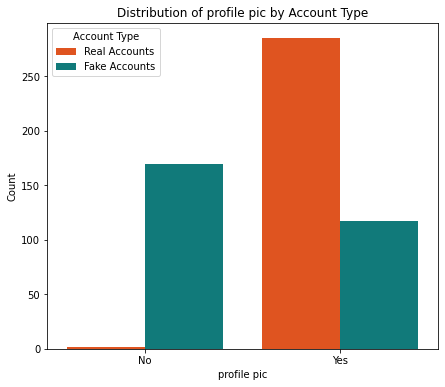

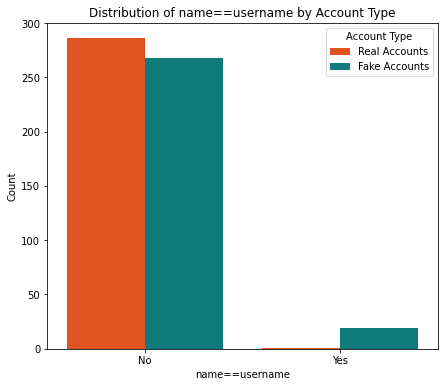

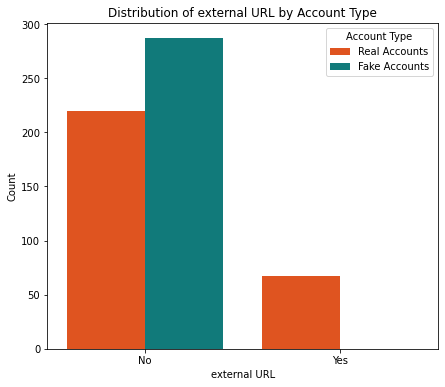

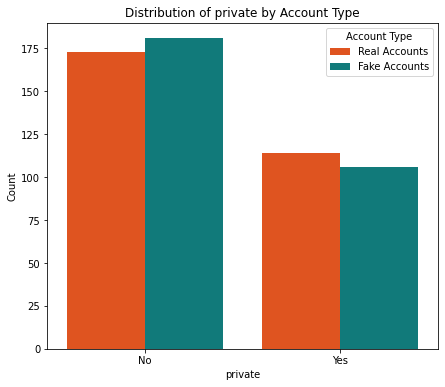

In [12]:
def crossbar(df):
    for feature in binary_features:
        plt.figure(figsize=(7, 6))
        sns.countplot(data=df, x=feature, hue='fake', palette={0: 'orangered', 1: 'darkcyan'})
        plt.title(f'Distribution of {feature} by Account Type')
        plt.legend(title='Account Type', labels=['Real Accounts', 'Fake Accounts'])
        plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
        plt.ylabel('Count')
        plt.xlabel(feature)
        plt.show()

# Let's visualize using the function
crossbar(training_data)


### Insights:

A significant number of accounts without profile pictures tend to be fake.

Predominantly, accounts where the name matches the username are categorized as fake.

Interestingly, all accounts that have an external URL in their bios appear to be real. However, a majority of accounts don't possess an external URL.

The bulk of accounts that are public (not private) lean towards being fake, whereas most of the private accounts are real.

### Continuous Features

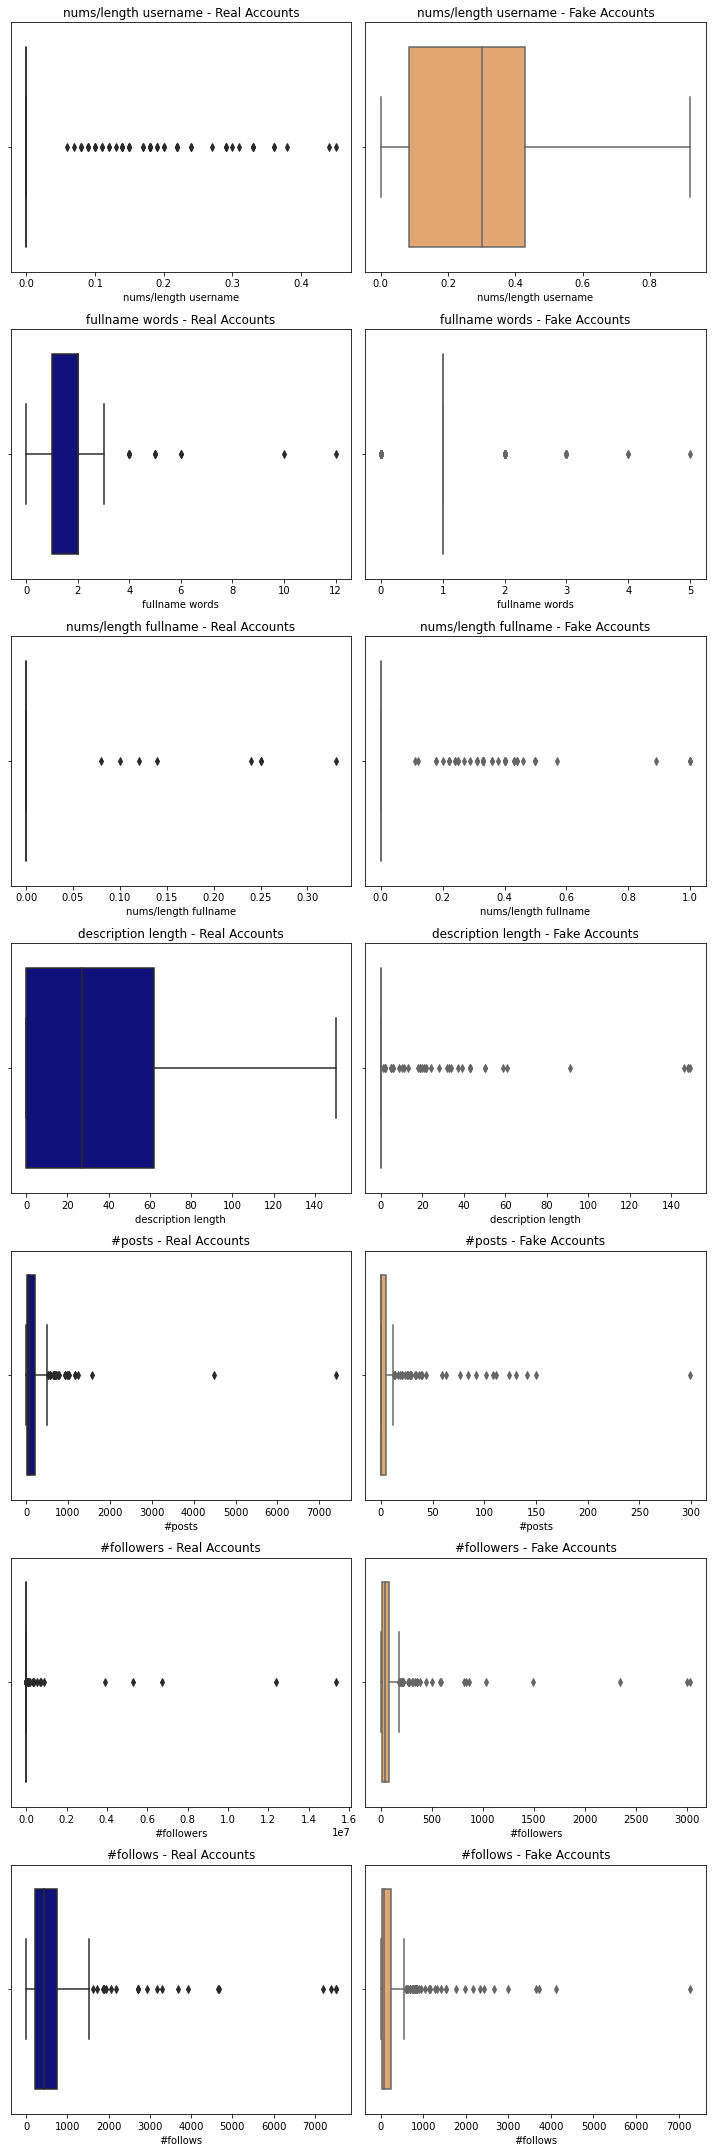

In [13]:
fig, axes = plt.subplots(nrows=len(continuous_features), ncols=2, figsize=(10, 30))

for i, col in enumerate(continuous_features):
    sns.boxplot(data=training_data[training_data['fake'] == 0], x=col, ax=axes[i, 0], color = 'darkblue')
    sns.boxplot(data=training_data[training_data['fake'] == 1], x=col, ax=axes[i, 1], color = 'sandybrown')
    axes[i, 0].set_title(col + " - Real Accounts")
    axes[i, 1].set_title(col + " - Fake Accounts")

plt.tight_layout()
plt.show()

### Insights:

-Usernames of fake accounts tend to contain a higher percentage of numbers.

-Fake accounts generally have fewer words in their full names.

-When we set aside outliers, fake accounts typically have much shorter descriptions for bios.

-Real accounts boast a significantly higher number of posts compared to their fake counterparts.

-Real accounts also have a substantially larger follower base than fake accounts.

On the whole, when we exclude the outliers, it appears that fake accounts, on average, follow fewer individuals compared to real accounts.

Due the number of outliers, we will build a Random Forest baseline and using Gradient Boosting Algorithms for predictions.

### Target Variable

In [14]:
fig = px.pie(legend_df, names='fake', title='Distribution of Target Variable', color_discrete_sequence = ['darkred','tomato'])
fig.update_layout(template = 'ggplot2')
fig.show()

### Baseline and Feature Selection

The baseline model serves as a reference point to compare the performance of other models and to also comprehend what roles each feature is playing when it comes to predicting the target variable. 
We can use the baseline model to measure the quality of our variables and even to look for the most relevant variables for feature engineering.

Random Forest Classifier is selected as a baseline, and the accuracy will be measured with the AUC-ROC score.

In [22]:
X = training_data.drop('fake', axis = 1)
y = training_data['fake']

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [24]:
random = RandomForestClassifier(random_state = 42)
random.fit(X_train, y_train) 

y_pred = random.predict(X_val) 

In [25]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_df = pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Thresholds': thresholds})

baseline_score = roc_auc_score(y_val, y_pred)
print('AUC-ROC Baseline: ', baseline_score.round(2))

AUC-ROC Baseline:  0.92


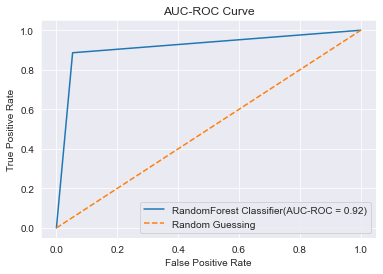



y_val value counts
0    94
1    79
Name: fake, dtype: int64


predicted value counts
(array([0, 1], dtype=int64), array([98, 75], dtype=int64))


In [26]:
sns.set_style('darkgrid')
sns.lineplot(x='FPR', y='TPR', data=roc_df, label=f'RandomForest Classifier(AUC-ROC = {baseline_score.round(2)})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guessing')
plt.title('AUC-ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print('\n')
print('y_val value counts')
print(y_val.value_counts())
print('\n')
print('predicted value counts')
print(np.unique(y_pred, return_counts=True))

The baseline model perfomed well, achieving an AUC-ROC score = 0.92

In the original y_val set, there were 94 genuine accounts and 79 fake ones. 
Our classifier's predictions consisted of 98 genuine accounts and 75 fake ones.

Moving on to feature selection, we'll leverage the SHAP library. A bar plot that highlights the significance of each feature in predicting our target variable.

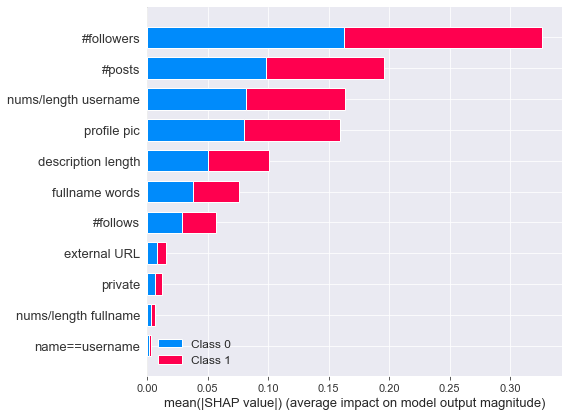

In [28]:
# Plotting Feature Importance plot
shap_values = shap.TreeExplainer(random).shap_values(X_val)
shap.summary_plot(shap_values, X_val, plot_type="bar")

It seems that, overall, all features impacted the output in someway or another, so we don't have any feature acting as a dead weight.

Knowing what the most relevant features were, we can now perform some feature engineering to create new features, preferably deriving from relevant attributes, to try to enhance the robustness of our final models' predicting abilities.

## Engineering New Features

Upon examining the data, I've identified two potential features that might be significant in predicting the target variable. Here they are:

* Activity Ratio: 
This metric gauges an account's posting activity relative to its follower count. It's calculated as: Activity Ratio = Number of Posts /Number of Followers

* Followers > #Follows?: 
Intuitively, I suspect that a large portion of fake accounts might have fewer followers compared to the number of accounts they follow. This binary feature will assign a value of either 0 or 1 to each account. A value of 1 indicates that the account has more followers than the number of accounts it follows. This could emerge as a significant predictor for our target.

These new features could provide additional insights and enhance the model's predictive accuracy.

In [30]:
# create activity ratio feature
training_data['activity ratio'] = np.round(training_data['#posts'] / training_data['#followers'], 2)

# Does the account have more followers than follows?
training_data['#followers > #follows?'] = (training_data['#followers'] > training_data['#follows']).astype(int)

In [31]:
training_data

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake,activity ratio,#followers > #follows?
0,1,0.27,0,0.00,0,53,0,0,32,1000,955,0,0.03,1
1,1,0.00,2,0.00,0,44,0,0,286,2740,533,0,0.10,1
2,1,0.10,2,0.00,0,0,0,1,13,159,98,0,0.08,1
3,1,0.00,1,0.00,0,82,0,0,679,414,651,0,1.64,0
4,1,0.00,2,0.00,0,0,0,1,6,151,126,0,0.04,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,1,0.55,1,0.44,0,0,0,0,33,166,596,1,0.20,0
572,1,0.38,1,0.33,0,21,0,0,44,66,75,1,0.67,0
573,1,0.57,2,0.00,0,0,0,0,4,96,339,1,0.04,0
574,1,0.57,1,0.00,0,11,0,0,0,57,73,1,0.00,0


In [36]:
fig = px.histogram(training_data, x=training_data['#followers > #follows?'], color=legend_df['fake'],
                   color_discrete_sequence=['#636EFA','#EF553B'],
                   barmode='group', template='plotly_white',labels={'color': 'Real/Fake'})
        
fig.update_layout(title='More Followers than Follows Distribution',
                  xaxis_title='#followers > #follows?', yaxis_title='Count', xaxis=dict(tickmode='array',
                  tickvals=[0, 1],
                  ticktext=['No', 'Yes']),
                  height = 800)
        
fig.show()

My initial hypothesis appears to be right! Accounts that follow more people than they have followers predominantly turn out to be fake. Conversely, accounts that boast more followers than the number they follow are typically genuine.

In [35]:
fig = px.box(training_data, x='fake', y='activity ratio', color = legend_df['fake'], title = "Activity Ratio")

fig.update_layout(xaxis_title="Real/Fake", yaxis_title='Count', xaxis=dict(tickmode='array',
                                                                               tickvals=[0, 1],
                                                                               ticktext=['Real Accounts', 'Fake Accounts']
                                                                               ),
                     height = 650)


fig.show()

Overall, real accounts have a higher activity ratio than fake accounts.
However, there are much more outliers, with an extremely positive activity ratio for fake accounts than for real accounts, which may also indicate something for our models when trying to predict the target variable.

After performing the feature engineering above, it's important to once again check for null and inf values.

In [33]:
training_data.isnull().sum()

profile pic                0
nums/length username       0
fullname words             0
nums/length fullname       0
name==username             0
description length         0
external URL               0
private                    0
#posts                     0
#followers                 0
#follows                   0
fake                       0
activity ratio            15
#followers > #follows?     0
dtype: int64

In [34]:
training_data.isin([np.inf, -np.inf]).sum()

profile pic               0
nums/length username      0
fullname words            0
nums/length fullname      0
name==username            0
description length        0
external URL              0
private                   0
#posts                    0
#followers                0
#follows                  0
fake                      0
activity ratio            3
#followers > #follows?    0
dtype: int64

In [41]:
# activity ratio generated infinite and missing values, replace them with NaN
training_data.replace([np.inf, -np.inf], np.nan, inplace=True)
training_data.dropna(inplace=True)

## Modeling

Before the modeling, I'll evaluate the means and standard deviations of all the features in our dataset. This will help determine if there's a need to rescale our data. 
By examining the means and standard deviations, we can gauge the relative scales of the features. If all features operate within a comparable value range, they'll likely contribute uniformly to the learning process.

In [42]:
# Measuring mean values and standard deviations
df_means = training_data.mean().round(2)
df_stds = training_data.std().round(2)
results = pd.concat([df_means, df_stds], axis = 1)
results.columns = ['Mean', 'Standard Deviation']
results

,Mean,Standard Deviation
profile pic,0.72,0.45
nums/length username,0.16,0.21
fullname words,1.47,1.06
nums/length fullname,0.04,0.13
name==username,0.03,0.18
description length,23.27,38.13
external URL,0.12,0.33
private,0.37,0.48
#posts,110.94,408.69
#followers,88366.21,926256.64


It's evident that certain features, like #followers and #follows, operate on a significantly larger scale compared to other features in the dataframe. This contrast can potentially skew our final models. For consistent value range, employing the Standard Scaler to rescale these features is crucial.

In [43]:
X = training_data.drop('fake', axis = 1)
y = training_data.fake

In [44]:
# Spitting data into training and validation sets. 
# 35% of data will be used for validation

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.35, random_state = 123)

XGBoost: AUC-ROC score = 0.90
LGBM: AUC-ROC score = 0.89
CatBoost: AUC-ROC score = 0.93
AdaBoost: AUC-ROC score = 0.89


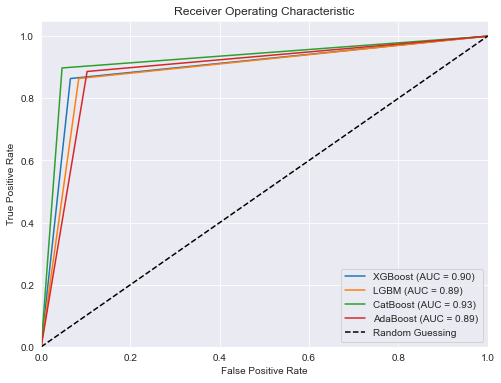

In [46]:
# Models
models = {
    "XGBoost": XGBClassifier(random_state = 42),
    "LGBM": LGBMClassifier(random_state = 42,  verbose=-1),
    "CatBoost": CatBoostClassifier(verbose=False, random_state = 42),
    "AdaBoost": AdaBoostClassifier(random_state = 42)
}

# Defining the pipeline process for each model
pipelines = {}
for name, model in models.items():
    pipelines[name] = Pipeline([
        ("scaler", StandardScaler()), # Rescaling data
        ("model", model) # Initializing model
    ])

# Computing AUC-ROC scores
results = {}
for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
    auc = roc_auc_score(y_val, y_pred)
    results[name] = {
        "pipeline": pipeline,
        "auc": auc
    }
    print(f"{name}: AUC-ROC score = {auc:.2f}")
    
# Plot AUC-ROC curve for all models
plt.figure(figsize=(8, 6))
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_val, result["pipeline"].predict(X_val))
    plt.plot(fpr, tpr, label=f"{name} (AUC = {result['auc']:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label = 'Random Guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Overall, most models didn't perform any better than the baseline. The CatBoost was the one that achieved the highest performance, being the only one that outperformed the baseline.

## Testing

In [47]:
# Creating activity ratio feature
testing_data['activity ratio'] = np.round(testing_data['#posts'] / testing_data['#followers'], 2)

# Does the account has more followers than follows?
testing_data['#followers > #follows?'] = (testing_data['#followers'] > testing_data['#follows']).astype(int)

In [48]:
testing_data.replace([np.inf, -np.inf], np.nan, inplace=True)
testing_data.dropna(inplace=True)

In [49]:
testing_data 

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake,activity ratio,#followers > #follows?
0,1,0.33,1,0.33,1,30,0,1,35,488,604,0,0.07,0
1,1,0.00,5,0.00,0,64,0,1,3,35,6,0,0.09,1
2,1,0.00,2,0.00,0,82,0,1,319,328,668,0,0.97,0
3,1,0.00,1,0.00,0,143,0,1,273,14890,7369,0,0.02,1
4,1,0.50,1,0.00,0,76,0,1,6,225,356,0,0.03,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,1,0.29,1,0.00,0,0,0,0,13,114,811,1,0.11,0
116,1,0.40,1,0.00,0,0,0,0,4,150,164,1,0.03,0
117,1,0.00,2,0.00,0,0,0,0,3,833,3572,1,0.00,0
118,0,0.17,1,0.00,0,0,0,0,1,219,1695,1,0.00,0


In [50]:
X = testing_data.drop('fake', axis = 1) 
y = testing_data.fake 

In [51]:
X 

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,activity ratio,#followers > #follows?
0,1,0.33,1,0.33,1,30,0,1,35,488,604,0.07,0
1,1,0.00,5,0.00,0,64,0,1,3,35,6,0.09,1
2,1,0.00,2,0.00,0,82,0,1,319,328,668,0.97,0
3,1,0.00,1,0.00,0,143,0,1,273,14890,7369,0.02,1
4,1,0.50,1,0.00,0,76,0,1,6,225,356,0.03,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,1,0.29,1,0.00,0,0,0,0,13,114,811,0.11,0
116,1,0.40,1,0.00,0,0,0,0,4,150,164,0.03,0
117,1,0.00,2,0.00,0,0,0,0,3,833,3572,0.00,0
118,0,0.17,1,0.00,0,0,0,0,1,219,1695,0.00,0


In [52]:
y.value_counts() 

0    60
1    56
Name: fake, dtype: int64

In [62]:
catboost_pipeline = results["CatBoost"]["pipeline"] # Creating a CatBoost model

y_pred = catboost_pipeline.predict(X) # Predicting on test data 

CatBoos: AUC-ROC score on unseen data = 0.9214


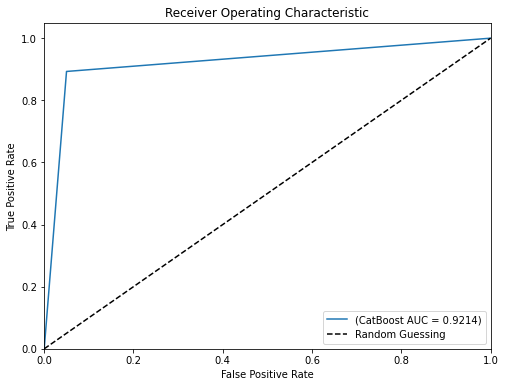

Value counts for y:
0    60
1    56
Name: fake, dtype: int64


Value counts for y_pred:
0    63
1    53
dtype: int64




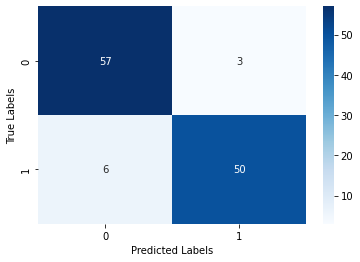



Recall Score: 89.0%


In [63]:
# Computing AUC-ROC score
auc = roc_auc_score(y, y_pred)
print(f"CatBoos: AUC-ROC score on unseen data = {auc:.4f}")

# Plotting ROC curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y, catboost_pipeline.predict(X))
plt.plot(fpr, tpr, label=f"(CatBoost AUC = {auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label = 'Random Guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Printing value counts
print("Value counts for y:")
print(y.value_counts())
print('\n')
print("Value counts for y_pred:")
print(pd.Series(y_pred).value_counts())
print('\n')
# Plotting confusion matrix
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True, cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
print('\n')
print(f'Recall Score: {np.round(recall_score(y, y_pred),2) * 100}%') # Printing Recall Score

The final model scored an AUC-ROC of 0.9214, which means it's doing well at spotting fakes.

Looking at the original y test, we had 60 real accounts and 56 fakes. 
Our model guessed 63 as real and 53 as fake. 

Finally, the Recall Score shows us that the model correctly flagged 89% of fake accounts, 50 out of 56.

## Model Explainability

Model explainability is important to understand how the model works and what was relevant during its classification process. 
It allows to understand the results we've achieved, as well as help us understand how effective the new features created were in predicting the target variable. Use the SHAP library for that.

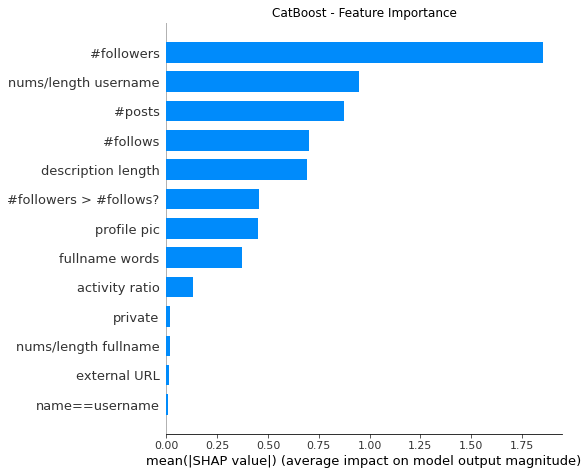

In [65]:
# Extracting the model and explainer
model = catboost_pipeline.named_steps['model']
explainer = shap.TreeExplainer(model)

# Computing the SHAP values
shap_values = explainer.shap_values(X_train)

# Summary plot
shap.summary_plot(shap_values, X, plot_type="bar", show=False)
plt.title('CatBoost - Feature Importance')
plt.tight_layout()
plt.show()

## Conclusion

During the development of this project, we performed multiple data treatment and data analysis tasks to identify patterns and extract insights from data.

We could successfully point to differences between fake accounts and real accounts on Instagram, by identifying that real accounts have more posts than fakes, and that fakes generally follow more people than real accounts, as well as other different traces between them.

By developing a baseline model, we've established a benchmark to compare our final models to. That also allowed us to understand what features displayed a high predicting importance of the target variable to the baseline model, which helped us to select relevant features for the feature engineering process.

After creating new features, we could also identify relevant patterns on them, such as the fact that most accounts following more people than they had followers were mostly fake accounts. This feature alone turned out to have somewhat significant impact on the final model output.

Finally, after testing a bunch of different Gradient Boosting algorithms, the CatBoost model achieved the higher AUC-ROC score, being picked to perform final predictions on the test dataset and efficiently scoring 0.9214 on the test set, correctly identifying 89% of fake accounts.